<a href="https://colab.research.google.com/github/VJalili/denovo/blob/main/denovo_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !gcloud init

In [2]:
# !gcloud auth application-default login

## Install Rapids

Install rapids in order to use GPU (e.g., for faster tsne).

Docs: https://docs.rapids.ai/deployment/stable/platforms/colab/

In [54]:
!nvidia-smi

Thu Aug  8 20:32:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [58]:
# !pip uninstall -y pyarrow cudf

Found existing installation: pyarrow 14.0.2
Uninstalling pyarrow-14.0.2:
  Successfully uninstalled pyarrow-14.0.2


In [59]:
# Colab warns and provides remediation steps if the GPUs is not compatible with RAPIDS.

# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing the rest of the RAPIDS 24.4.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
  Using cached pyarrow-14.0.2-cp310-cp310-manylinux_2_28_x86_64.whl (38.0 MB)

        ***********************************************************************
        The pip install of RAPIDS is complete.
        
        Please do not run any further installation from the conda based installation methods, as they may cause issues!
        
        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files. 
            - If an installation failure persists when using the latest script, please make an issue on https://github.com/rapidsai-community/rapidsai

In [61]:
# !pip install pyarrow==13.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 13.0.0 which is incompatible.


In [35]:
import cudf
import cuml
from cuml.manifold import TSNE as TSNE_cuml

In [9]:
import os
import pandas as pd
import gzip

from dataclasses import dataclass, field
from google.cloud import storage
from pathlib import Path
from typing import Callable, Any, Dict, Tuple, List

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [10]:
storage_client = storage.Client(project="broad-dsde-methods")

# This method uses the Google cloud storage library which performs faster
# calling gsutil using `check_output`.
def download_blob(bucket_name, blob_name, local_filename):
  bucket = storage_client.get_bucket(bucket_name)
  blob = bucket.blob(blob_name)
  blob.download_to_filename(local_filename)

def copy_object_to_bucket(bucket_name, blob_name, source_filename):
  bucket = storage_client.get_bucket(bucket_name)
  blob = bucket.blob(blob_name)
  blob.upload_from_filename(source_filename)

In [11]:
working_dir = os.path.join(".", "denovo")
if not os.path.exists(working_dir):
  os.makedirs(working_dir)

In [12]:
bucket_name = "broad-dsde-methods-vj"
base_blob_name = "denovo-sv"
def resolve_filename(filename):
  local_filename = os.path.join(working_dir, filename)
  if not os.path.isfile(local_filename):
    download_blob(bucket_name, f"{base_blob_name}/{filename}", local_filename)
    print(f"Localized {filename}")
  else:
    print(f"File is already localized, filename: {local_filename}")
  return local_filename

filename = "GMKF-OFC-denovo-SV-Master-20240314_non_cnv_only.csv"
denovo_svs_filename = resolve_filename(filename)

File is already localized, filename: ./denovo/GMKF-OFC-denovo-SV-Master-20240314_non_cnv_only.csv


In [13]:
df = pd.read_csv(denovo_svs_filename, sep=",")
df = df.drop(columns=["chrom", "start", "end", "sample"])
df.shape

(5974, 90)

In [14]:
cols_with_nan = []
for column in df.columns:
  nan_count = df[column].isna().sum()
  if nan_count > 0:
    cols_with_nan.append([column, nan_count])

In [15]:
cols_with_nan

[['RD_CN', 5974],
 ['RD_GQ', 5974],
 ['paternal_rdcn', 5974],
 ['maternal_rdcn', 5974],
 ['median_coverage', 5974],
 ['result_final', 2643]]

In [16]:
cols_with_nan_col_name = [x[0] for x in cols_with_nan]
df.drop(columns=cols_with_nan_col_name, inplace=True)

In [17]:
df.shape

(5974, 84)

In [18]:
cols_of_obj_type = df.select_dtypes(include=['object']).columns
df.drop(columns=cols_of_obj_type, inplace=True)

In [19]:
df.shape

(5974, 79)

In [20]:
# nan_df = df[df["RD_CN"].isna()]

In [21]:
# nan_df.to_csv("nan_rdcn.tsv", sep="\t")

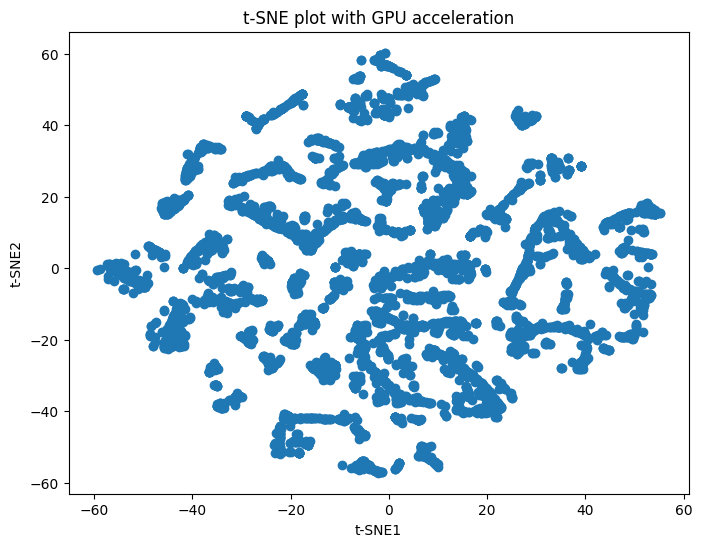

In [41]:
gdf = cudf.DataFrame.from_pandas(df)
gpu_matrix = gdf.to_cupy()
tsne_model = TSNE_cuml(n_components=2, random_state=42)
tsne_results = tsne_model.fit_transform(gpu_matrix)

# Convert the t-SNE results to a numpy array using `.get()` for plotting
tsne_results_np = tsne_results.get()

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_np[:, 0], tsne_results_np[:, 1])
plt.title('t-SNE plot with GPU acceleration')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()